In [6]:
%load_ext autoreload
%autoreload 2
import math
from matplotlib import pyplot as plt
from train_box_model import initialize_model_and_state, OptimCfg
from jax.random import PRNGKey, split, normal
from box_model import make_box, rot_axis_to_quaternion, draw_box, overimpose_point_cloud, simulate, draw_box_no_bar
from jax import numpy as jnp
from jax import vmap, grad, value_and_grad
import jax

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
m, tx, opt_state, params, state = initialize_model_and_state(
        key=PRNGKey(1574),
        obs_length=100,
        optim_cfg=OptimCfg(),
        num_input_vars=3,
        load_idx=0,
        chkpt_folder="box_chkpts_high_cap_3/",
        deterministic = True,
    )

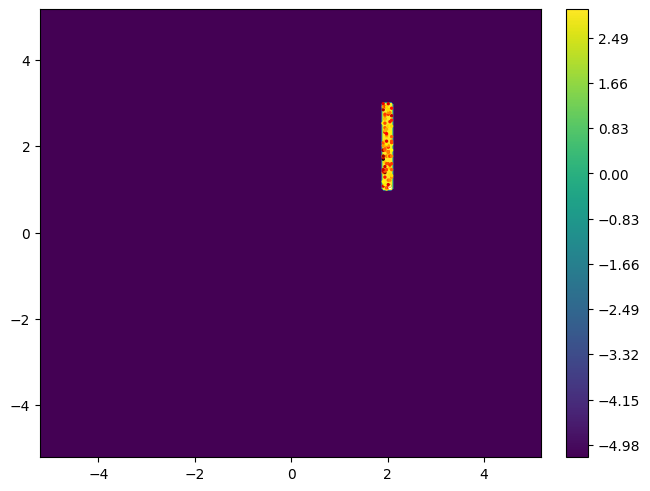

In [8]:
hx=1.0
hy=.10
hz=1.0
q=rot_axis_to_quaternion(jnp.array([1,1.0,1.0])/3**0.5,jnp.array(0.001))
# q=rot_axis_to_quaternion(jnp.array([0,0,-1.0]),jnp.pi/2)
# hx,hy,hz = 1.0361311 ,  0.84753823,  0.21451688,
# q = jnp.array([0.24576879, -0.41609514, 0.0858047 ,  0.5095999])
# qn = jnp.linalg.norm(q)
# q /= qn
t=jnp.array([2.0,2.0,2.0])
latents = jnp.concatenate([jnp.stack([hx, hy, hz]), t, q])
pc, box = simulate(PRNGKey(0), latents, obs_noise_std=0.02, num_points=100)
def loss(l1,k):
    pc1, _ = simulate(PRNGKey(k), l1, obs_noise_std=0.02, num_points=100)
    return ((pc1-pc)**2).mean()
ax,fig = draw_box(box)
overimpose_point_cloud(fig, ax, pc)
# l1 = s[15]
# k = PRNGKeyey(568)
# for _ in range(1000):
#     k,sk = split(k)
#     lv, g = value_and_grad(loss)(jax.lax.stop_gradient(l1),sk)
#     l1 = l1 - 0.01 * g
#     print(lv)

In [9]:
num_samples = 25
my_sample = vmap(lambda k: m.apply(
    {"params": params, **state},
            pc[None],
            latents[None],
            rngs={"rsample_key": k,},)[1][0])
s = my_sample(split(PRNGKey(1),num_samples))
idx = ((s[:,:]-latents[None])**2).sum(-1).argsort()
s = s[idx]
s[:,:3]

DeviceArray([[ 1.0500982 ,  0.24019241,  0.749841  ],
             [ 0.90527534,  0.10358524,  1.4279993 ],
             [ 0.8474703 ,  0.42872667,  0.65261865],
             [ 0.71064734,  0.40340066,  0.7051301 ],
             [ 0.6104288 ,  0.5115411 ,  1.1467972 ],
             [ 0.8469193 , -0.10801506,  1.7032101 ],
             [ 0.8319659 ,  0.755456  ,  1.0957491 ],
             [ 0.3850832 ,  0.28847027,  1.5879889 ],
             [ 0.3482604 ,  0.3747921 ,  1.5517898 ],
             [ 0.85601187,  0.8380861 ,  0.49051404],
             [ 0.278661  ,  0.40932631,  1.5438347 ],
             [ 0.66022396,  0.7017791 ,  0.3672619 ],
             [ 0.7188721 ,  0.4298563 ,  0.87855387],
             [ 0.8336179 ,  0.45326138,  0.7583003 ],
             [ 0.69087386,  0.48649192,  1.3453748 ],
             [ 0.566978  ,  0.40119243,  1.3027377 ],
             [ 0.5856967 ,  0.13927436,  1.5829191 ],
             [ 0.64711237,  0.08056259,  1.6457884 ],
             [ 1.2565038 ,  

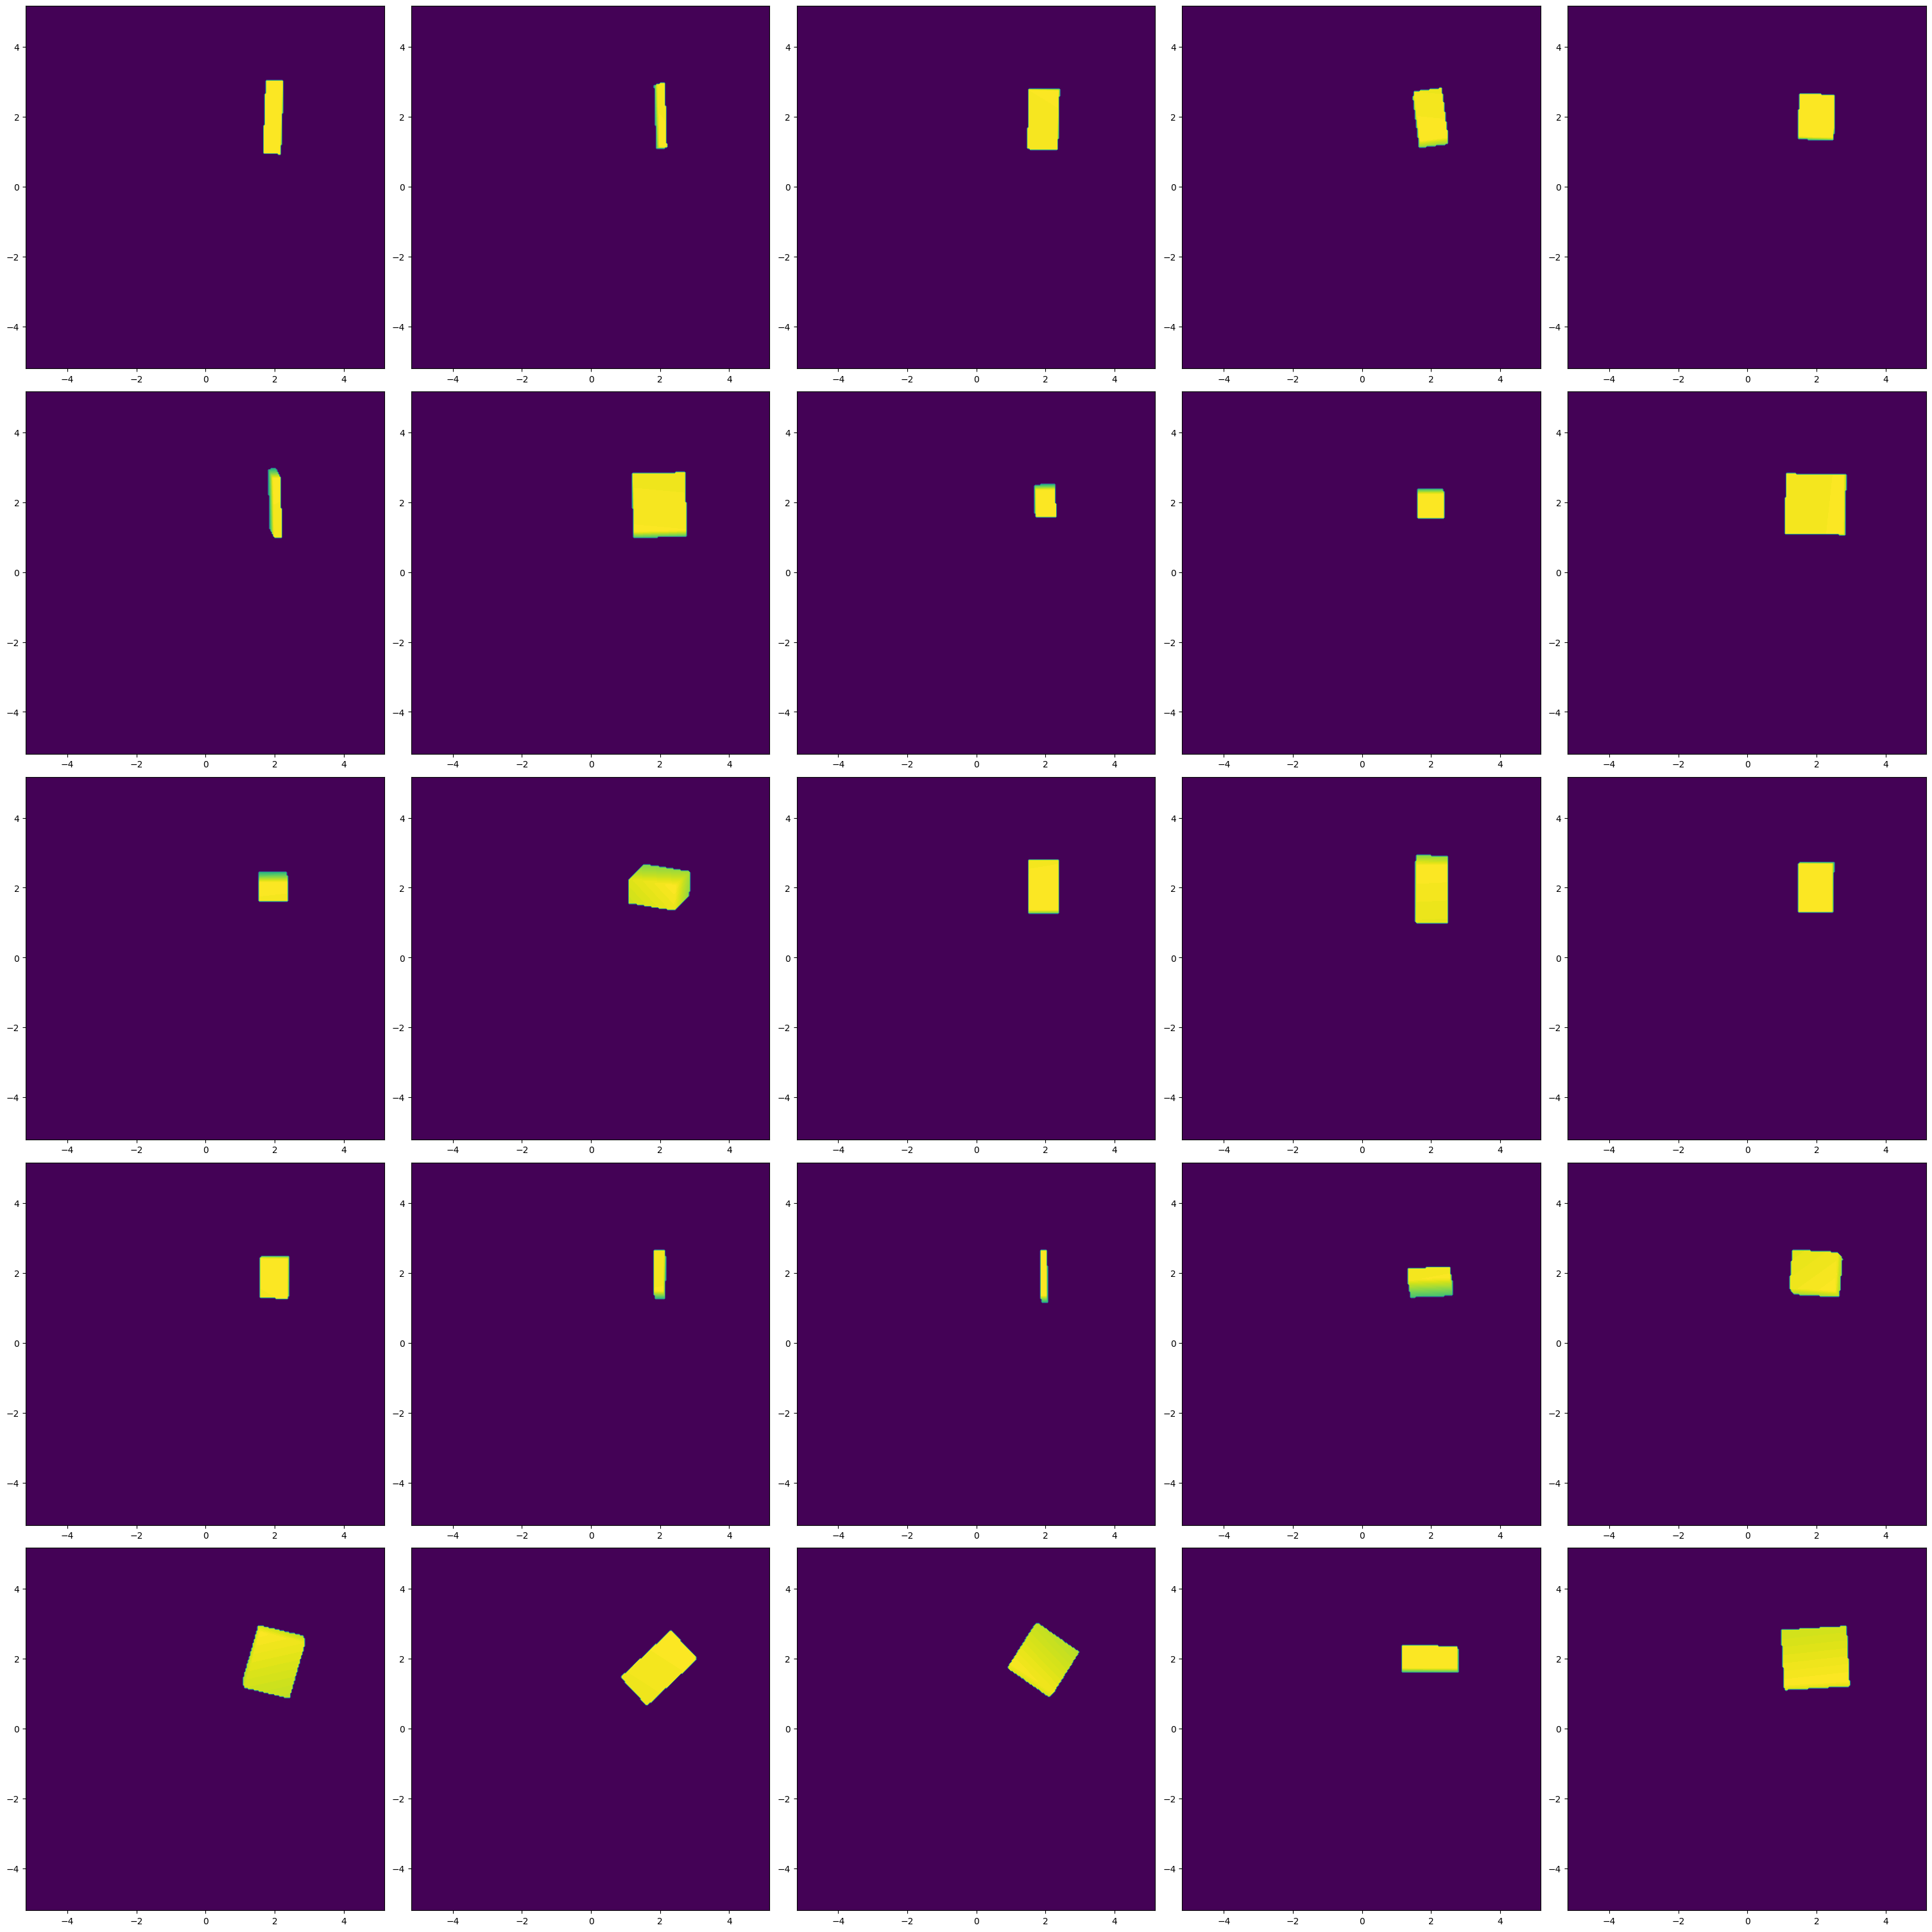

In [10]:
num_plots = num_samples
num_cols = 5
num_rows = math.ceil(num_plots/num_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30,30), constrained_layout=True)

for i in range(num_plots):
    c = i % num_cols
    r = math.floor(i/num_cols)
    hx, hy, hz = s[i,:3]
    t = s[i,3:6]
    q = s[i,6:]
    qn = jnp.linalg.norm(q)
    q/=qn
    box = make_box(hx, hy, hz, t, q)
    draw_box_no_bar(box, axes[r,c])

In [26]:
import optax
from flax import linen as nn
schedule = optax.cosine_onecycle_schedule(1000, 1e-1,pct_start=0.2, div_factor=100.0, final_div_factor=10000.0)
tx = optax.chain(optax.clip(1.0),optax.adam(learning_rate=schedule))
m = nn.Dense(100)
params = m.init(PRNGKey(0), jnp.ones((1000,10)))['params']
loss = lambda x: m.apply({'params':x},jnp.ones((1000,10))).mean()
opt_state = tx.init(params)

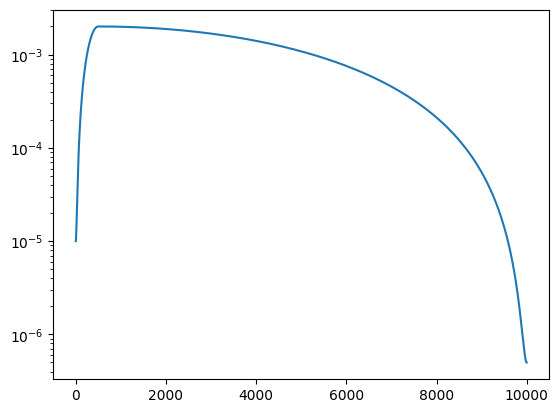

In [8]:
import optax
schedule = optax.cosine_onecycle_schedule(10000, 2e-3,pct_start=0.05, div_factor=2e2, final_div_factor=2e1)
lrs = vmap(schedule)(jnp.arange(10000))
plt.plot(lrs)
plt.yscale('log')